In [1]:
import pandas as pd
import mysql.connector as connection
import matplotlib.pyplot as plt
import importlib
import json
import seaborn as sns
import geopandas as gpd
from shapely import wkt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
import plotly.express as px
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder
import plotly.express as px
from collections import Counter
from itertools import product
import scipy.stats as stats
import fiona
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
import itertools

## Prerequisites
First, you should install mysql in the version that is required by Meirim, currently version 5.7. <br/>
Second, you should setup your databse and npm as instructed in [Meirim's Github](https://github.com/meirim-org/meirim) <br/>
Third, you should run 
```
pip install -r requirements.txt
```
Fourth, you should run Meirim's cralwer in order to fill your database with plans. Look for the section "Instructions for crawler" in [Meirim's Github](https://github.com/meirim-org/meirim)

Please run this notebook after you have your database filled with data of plans.


## Exploratory

In [2]:
def get_mysql_con():
    return connection.connect(host="localhost", database='meirim', user="root", passwd="password", use_pure=True)


def get_status_changes_df():
    with get_mysql_con() as db_connection:
        status_df = pd.read_sql("SELECT * FROM plan_status_change", db_connection)
    
    status_df['date'] = pd.to_datetime(status_df['date'])
    status_df['year'] = status_df['date'].dt.year
    status_df['month'] = status_df['date'].dt.month
    
    print(f'number of plans with status change: {status_df["plan_id"].nunique()}')
    return status_df

status_df = get_status_changes_df()
status_df.head()

/var/folders/l5/f4qh10xj78l_nszjzjcnf_th0000gr/T/ipykernel_13866/3149582350.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  status_df = pd.read_sql("SELECT * FROM plan_status_change", db_connection)


number of plans with status change: 22803


,id,plan_id,status,date,status_description,created_at,updated_at,year,month
0,1,321,התכנית אושרה,2017-08-31 09:00:00,,2021-11-19 11:35:09,2021-11-19 11:35:09,2017,8
1,2,321,רישום התכנית שהטיפול בה הסתיים,2017-08-31 09:00:00,,2021-11-19 11:35:09,2021-11-19 11:35:09,2017,8
2,3,321,פרסום לאישור ברשומות,2017-08-31 09:00:00,תאריך פרסום: 31/08/2017. מס' ילקוט פרסומים: 7...,2021-11-19 11:35:09,2021-11-19 11:35:09,2017,8
3,4,321,פרסום להפקדה ברשומות,2017-05-04 09:00:00,תאריך פרסום: 04/05/2017. מס' ילקוט פרסומים: 7...,2021-11-19 11:35:09,2021-11-19 11:35:09,2017,5
4,5,321,בדיקת תנאי סף-קיום תנאי סף,2016-06-06 09:00:00,,2021-11-19 11:35:09,2021-11-19 11:35:09,2016,6


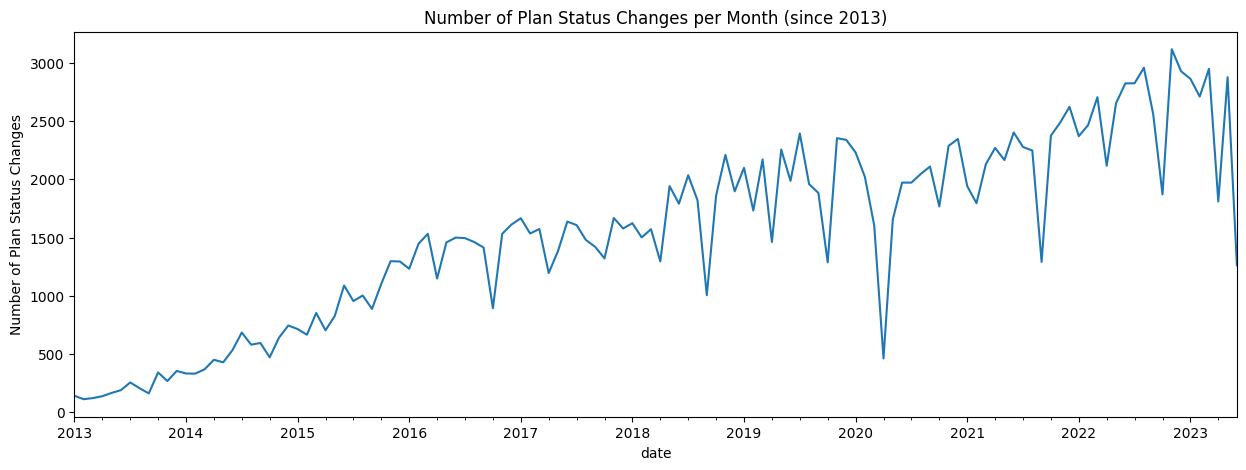

In [3]:
plot_df = status_df.copy()
plot_df = plot_df[plot_df['year'] > 2012]
plot_df['date'] = pd.to_datetime(plot_df[['year', 'month']].assign(day=1))
num_of_status_changes_per_month = plot_df.groupby('date').size()

fig, ax = plt.subplots(figsize=(15, 5))
num_of_status_changes_per_month.plot(kind='line', ax=ax)
plt.ylabel('Number of Plan Status Changes')
plt.title('Number of Plan Status Changes per Month (since 2013)')
plt.show()

In [4]:
def get_meirim_status_mapper():
    with open('mavat_status_to_meirim_status.json', 'r') as fd:
        mavat_to_meirim_status_mapper = json.load(fd)

    # this will map statuses that came from mavat to meirim's statuses which are more indicative of the plan's progress
    # and Meirim's statuses group statuses from mavat together
    mavat_to_meirim_status_mapper = {dct['mavat_status']: dct['meirim_status'] for dct in mavat_to_meirim_status_mapper}
    return mavat_to_meirim_status_mapper

# this will map statuses that came from mavat to meirim's statuses which are more indicative of the plan's progress
# and Meirim's statuses group statuses from mavat together
mavat_to_meirim_status_mapper = get_meirim_status_mapper()

print(set(mavat_to_meirim_status_mapper.values()))

{'הסכמה עקרונית', 'תכנית מבוטלת', 'תכנית מאושרת', 'התנגדויות והערות הציבור', 'הכנת תכנית', 'על שולחן הוועדה'}


In [5]:
print(f'Mavat has {status_df["status"].nunique()} different statuses while Meirim has {len(set(mavat_to_meirim_status_mapper.values()))} statuses')
status_df['status'].unique()[:10]

Mavat has 126 different statuses while Meirim has 6 statuses


array(['התכנית אושרה', 'רישום התכנית שהטיפול בה הסתיים',
       'פרסום לאישור ברשומות', 'פרסום להפקדה ברשומות',
       'בדיקת תנאי סף-קיום תנאי סף',
       'פרסום הודעה בדבר אישור תכנית באתר אינטרנט',
       'עיון שר האוצר-התכנית לא טעונה אישור השר', 'פרסום לאישור בעיתונים',
       'החלטה בדיון באישור תכנית', 'לא הוגשו התנגדויות'], dtype=object)

In [6]:
def integrate_meirim_statuses_into_statuses_df(status_df, mavat_to_meirim_status_mapper):
    status_df['meirim_status'] = status_df['status'].map(mavat_to_meirim_status_mapper)
    print(f"Amount of statuses that do not exist in Meirim's Statuses: {status_df['meirim_status'].isna().sum() / len(status_df) * 100:.2f}%")


integrate_meirim_statuses_into_statuses_df(status_df, mavat_to_meirim_status_mapper)

Amount of statuses that do not exist in Meirim's Statuses: 18.55%


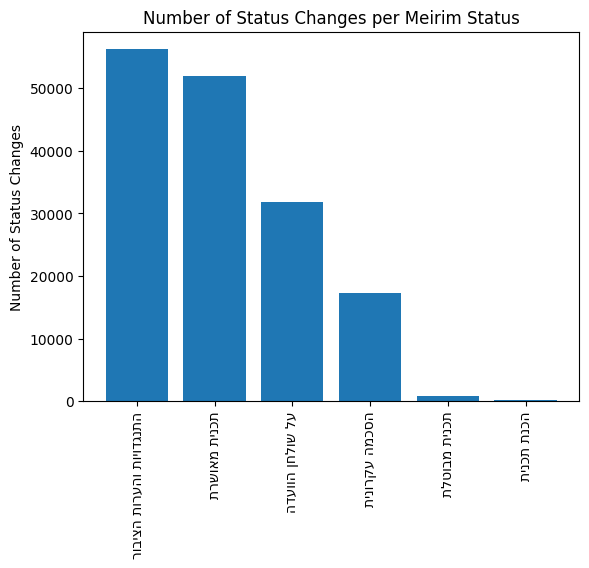

In [7]:
plt.bar([val[::-1] for val in status_df['meirim_status'].value_counts().index], status_df['meirim_status'].value_counts().values)
plt.xticks(rotation=90)
plt.ylabel('Number of Status Changes')
plt.title('Number of Status Changes per Meirim Status')

plt.show()

Plans can have multiple statuses in each bin. For example, a plan can have 2 different statuses that denote the plan is in objections and comments from the public, since each one is slightly different but Meirim grouped them together.

In [8]:
def get_plan_df():
    with get_mysql_con() as db_connection:
        plan_df = pd.read_sql("SELECT id, PL_NUMBER, PL_NAME, PLAN_COUNTY_NAME, jurisdiction, ST_ASTEXT(geom) as geom FROM plan", db_connection)
    
    plan_df['geom'] = plan_df['geom'].apply(lambda x: wkt.loads(x))
    plan_df = gpd.GeoDataFrame(plan_df, geometry='geom')
    # Set the CRS of the GeoDataFrame to WGS84 (EPSG:4326)
    plan_df = plan_df.set_crs('EPSG:4326')
    # Reproject to an equal area projection
    eq_area_plan_df = plan_df.to_crs(epsg=6933)
    plan_df['area_in_sqm'] = eq_area_plan_df.area
    plan_df = plan_df[(plan_df['jurisdiction'] == 'מקומית') | (plan_df['jurisdiction'] == 'מחוזית')].reset_index(drop=True).copy()
    print(f'The plan table has {plan_df.shape[0]} plans')
    return plan_df

plan_df = get_plan_df()

plan_df.head()

/var/folders/l5/f4qh10xj78l_nszjzjcnf_th0000gr/T/ipykernel_13866/1453677256.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  plan_df = pd.read_sql("SELECT id, PL_NUMBER, PL_NAME, PLAN_COUNTY_NAME, jurisdiction, ST_ASTEXT(geom) as geom FROM plan", db_connection)


The plan table has 29121 plans


,id,PL_NUMBER,PL_NAME,PLAN_COUNTY_NAME,jurisdiction,geom,area_in_sqm
0,1,410-0283192,"קיטרוני 47 - תוספת יח""ד",,מקומית,"POLYGON ((34.89035 32.08096, 34.89042 32.08077...",987.734806
1,2,602-0278747_dup_,"מגרש 141, שכונת שחמון רובע 8, אילת",,מקומית,"POLYGON ((34.93275 29.54547, 34.93257 29.54559...",4365.439444
2,3,302-0211433,"בנייני מגורים ומסחר, חדרה.",חדרה,מקומית,"POLYGON ((34.91553 32.43597, 34.91560 32.43617...",7143.285295
3,4,451-0380188,חלוקת מגרש לשני מגרשים נפרדים ושינוי הוראות בניה,כפר קאסם,מקומית,"POLYGON ((34.97343 32.11656, 34.97343 32.11675...",793.010204
4,5,416-0385286,"רע/מק/838 - משה סנה 5 רעננה - הרחבת יח""ד",רעננה,מקומית,"POLYGON ((34.85148 32.19477, 34.85122 32.19474...",1437.083477


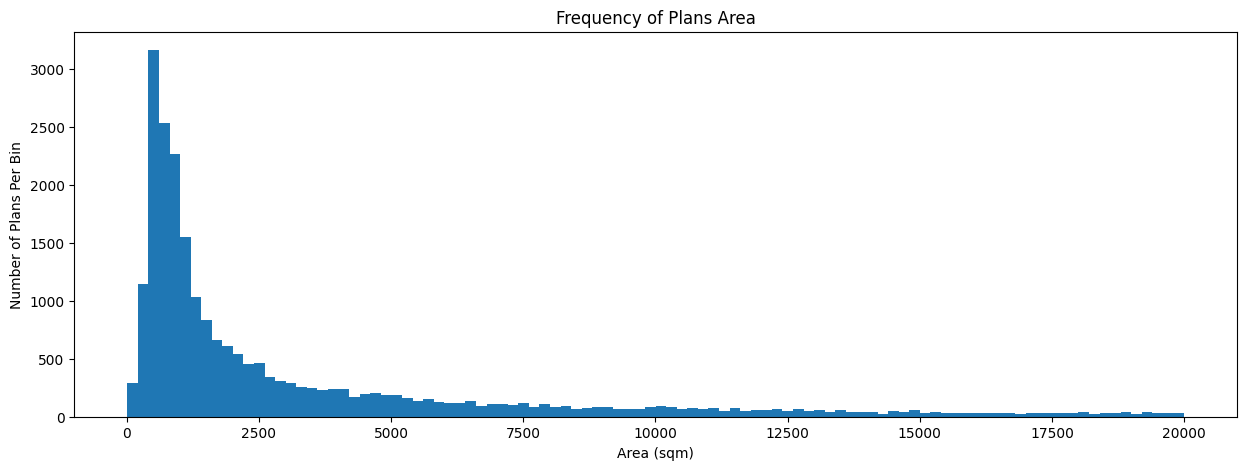

In [9]:
areas_no_outliers = plan_df['area_in_sqm'][plan_df['area_in_sqm'] < 20_000]
plt.figure(figsize=(15, 5))
plt.hist(areas_no_outliers, bins=100)

plt.title('Frequency of Plans Area')
plt.xlabel('Area (sqm)')
plt.ylabel('Number of Plans Per Bin')
plt.show()

In [10]:
plan_df['jurisdiction'].value_counts()

jurisdiction
מקומית    14823
מחוזית    14298
Name: count, dtype: int64

Local and district comittees contains about the same number of plans.

In [11]:
print(f'{(plan_df["PLAN_COUNTY_NAME"] == "").sum() / plan_df.shape[0] * 100:.2f}% of plans have no county name')

print('Top 10 counties with the most plans:')
plan_df['PLAN_COUNTY_NAME'].value_counts().iloc[:10]

14.25% of plans have no county name
Top 10 counties with the most plans:


PLAN_COUNTY_NAME
               4150
ירושלים        3379
באר שבע         620
בני ברק         606
חיפה            517
סח'נין          429
נתניה           405
רהט             392
חדרה            387
ראשון לציון     369
Name: count, dtype: int64

In [12]:
def get_first_and_last_status_change_per_plan(status_df):
    status_df_sorted = status_df.sort_values(by='date')
    first_status_of_each_plan = status_df_sorted.groupby('plan_id').first().reset_index()
    last_status_of_each_plan = status_df_sorted.groupby('plan_id').last().reset_index()
    first_and_last_status_of_each_plan = pd.merge(first_status_of_each_plan, last_status_of_each_plan, on='plan_id', suffixes=('_first', '_last'))
    return first_and_last_status_of_each_plan

first_and_last_status_of_each_plan = get_first_and_last_status_change_per_plan(status_df)

first_and_last_status_of_each_plan.head()

,plan_id,id_first,status_first,date_first,status_description_first,created_at_first,updated_at_first,year_first,month_first,meirim_status_first,id_last,status_last,date_last,status_description_last,created_at_last,updated_at_last,year_last,month_last,meirim_status_last
0,1,4377,בדיקת תנאי סף-קיום תנאי סף,2015-07-09 09:00:00,None,2023-05-26 15:32:00,2023-05-26 15:32:00,2015,7,על שולחן הוועדה,4377,בדיקת תנאי סף-קיום תנאי סף,2015-07-09 09:00:00,None,2023-05-26 15:32:00,2023-05-26 15:32:00,2015,7,על שולחן הוועדה
1,10,10929,קבלת תכנית,2016-08-15 09:00:00,,2023-05-27 17:46:19,2023-05-27 17:46:19,2016,8,על שולחן הוועדה,10913,הפקת מסמך בדבר העברת התכנית המאושרת למשרדי הוו...,2017-05-08 09:00:00,,2023-05-27 17:46:19,2023-05-27 17:46:19,2017,5,תכנית מאושרת
2,100,70023,קבלת תכנית,2011-10-03 09:00:00,,2023-06-06 02:02:10,2023-06-06 02:02:10,2011,10,על שולחן הוועדה,70008,התכנית אושרה,2014-12-03 09:00:00,,2023-06-06 02:02:10,2023-06-06 02:02:10,2014,12,תכנית מאושרת
3,1000,156691,פרסום להפקדה ברשומות,2016-07-21 09:00:00,תאריך פרסום: 21/07/2016. מס' ילקוט פרסומים: 7...,2023-06-06 22:22:31,2023-06-06 22:22:31,2016,7,התנגדויות והערות הציבור,156688,התכנית אושרה,2016-12-06 09:00:00,,2023-06-06 22:22:31,2023-06-06 22:22:31,2016,12,תכנית מאושרת
4,10000,14977,קבלת תכנית,2016-09-06 09:00:00,,2023-05-29 18:20:36,2023-05-29 18:20:36,2016,9,על שולחן הוועדה,14963,הפקת מסמך בדבר העברת התכנית המאושרת למשרדי הוו...,2018-08-20 09:00:00,,2023-05-29 18:20:36,2023-05-29 18:20:36,2018,8,תכנית מאושרת


In [13]:
def get_only_plans_with_consistent_statuses_and_approved(first_and_last_status_of_each_plan):
    df = first_and_last_status_of_each_plan
    df = df[df['id_first'] != df['id_last']]
    
    must_be_first_statuses = ['על שולחן הוועדה', 'הכנת תכנית']
    must_be_last_statuses = ['תכנית מאושרת']
    df = df[df['meirim_status_first'].isin(must_be_first_statuses)]
    # will also drop plans in progress
    df = df[df['meirim_status_last'].isin(must_be_last_statuses)]

    df['time_to_answer'] = df['date_last'] - df['date_first']
    
    print(f'Number of plans with inconsistent statuses or not approved plans: {(first_and_last_status_of_each_plan.shape[0] - df.shape[0]) / first_and_last_status_of_each_plan.shape[0] * 100:.2f}%')
    return df

first_and_last_status_of_each_plan_consistent = get_only_plans_with_consistent_statuses_and_approved(first_and_last_status_of_each_plan)

first_and_last_status_of_each_plan_consistent.head()

Number of plans with inconsistent statuses or not approved plans: 40.32%


,plan_id,id_first,status_first,date_first,status_description_first,created_at_first,updated_at_first,year_first,month_first,meirim_status_first,id_last,status_last,date_last,status_description_last,created_at_last,updated_at_last,year_last,month_last,meirim_status_last,time_to_answer
1,10,10929,קבלת תכנית,2016-08-15 09:00:00,,2023-05-27 17:46:19,2023-05-27 17:46:19,2016,8,על שולחן הוועדה,10913,הפקת מסמך בדבר העברת התכנית המאושרת למשרדי הוו...,2017-05-08 09:00:00,,2023-05-27 17:46:19,2023-05-27 17:46:19,2017,5,תכנית מאושרת,266 days
2,100,70023,קבלת תכנית,2011-10-03 09:00:00,,2023-06-06 02:02:10,2023-06-06 02:02:10,2011,10,על שולחן הוועדה,70008,התכנית אושרה,2014-12-03 09:00:00,,2023-06-06 02:02:10,2023-06-06 02:02:10,2014,12,תכנית מאושרת,1157 days
4,10000,14977,קבלת תכנית,2016-09-06 09:00:00,,2023-05-29 18:20:36,2023-05-29 18:20:36,2016,9,על שולחן הוועדה,14963,הפקת מסמך בדבר העברת התכנית המאושרת למשרדי הוו...,2018-08-20 09:00:00,,2023-05-29 18:20:36,2023-05-29 18:20:36,2018,8,תכנית מאושרת,713 days
5,10001,15647,קבלת תכנית,2017-01-09 09:00:00,,2023-05-29 18:30:26,2023-05-29 18:30:26,2017,1,על שולחן הוועדה,15632,התכנית אושרה,2018-07-09 09:00:00,,2023-05-29 18:30:26,2023-05-29 18:30:26,2018,7,תכנית מאושרת,546 days
9,10010,21713,קבלת תכנית,2017-12-27 09:00:00,,2023-05-29 19:52:41,2023-05-29 19:52:41,2017,12,על שולחן הוועדה,21702,פרסום לאישור ברשומות,2019-01-17 09:00:00,תאריך פרסום: 17/01/2019. מס' ילקוט פרסומים: 8...,2023-05-29 19:52:41,2023-05-29 19:52:41,2019,1,תכנית מאושרת,386 days


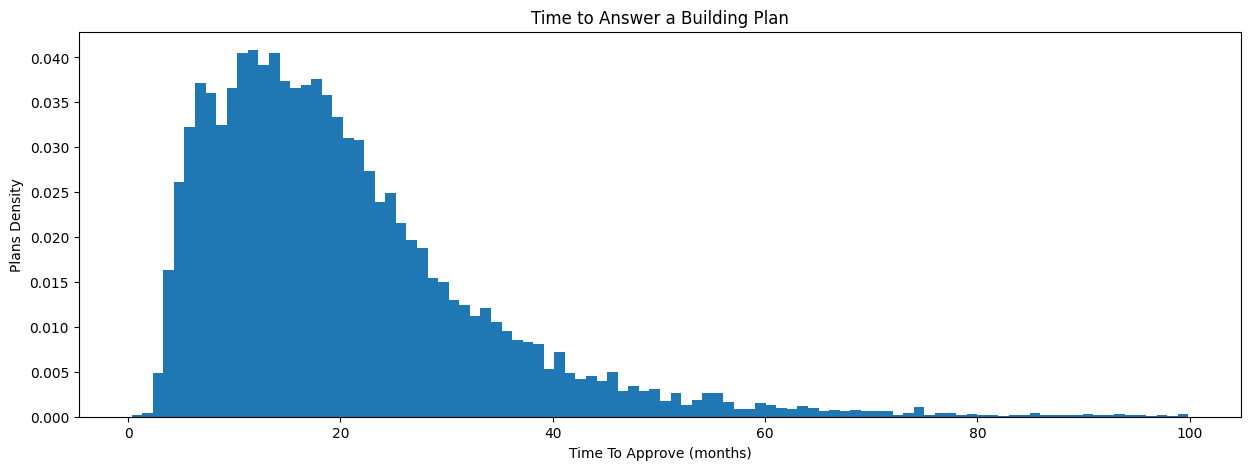

In [14]:
time_to_answer_no_outliers = first_and_last_status_of_each_plan_consistent['time_to_answer'].dt.days / 30
time_to_answer_no_outliers = time_to_answer_no_outliers[time_to_answer_no_outliers < 100]

# plot on screen
plt.figure(figsize=(15, 5))
plt.hist(time_to_answer_no_outliers, bins=100, density=True)
plt.title('Time to Answer a Building Plan')
plt.xlabel('Time To Approve (months)')
plt.ylabel('Plans Density')
plt.show()

# save to PDF
plt.figure(figsize=(7, 5))
plt.hist(time_to_answer_no_outliers, bins=100, density=True)
plt.xlabel('Time To Approve (months)')
plt.ylabel('Plans Density')
plt.savefig('time_to_approve.pdf')
plt.close()

In [16]:
def merge_time_to_decision_with_plan_df(plan_df, time_to_answer_df):
    print(f'{plan_df.shape[0]} plans before merging with time to decision')
    
    plan_df_with_time_to_decision = pd.merge(plan_df, time_to_answer_df[['plan_id', 'time_to_answer']], left_on='id', right_on='plan_id', how='left')
    plan_df_with_time_to_decision = plan_df_with_time_to_decision.drop(columns=['plan_id'])
    
    plan_df_with_time_to_decision = plan_df_with_time_to_decision[~plan_df_with_time_to_decision['time_to_answer'].isna()].copy()
    plan_df_with_time_to_decision['time_to_answer_days'] = plan_df_with_time_to_decision['time_to_answer'].dt.days

    number_no_time_to_decision = plan_df.shape[0] - plan_df_with_time_to_decision.shape[0]
    percentage_no_time_to_decision = number_no_time_to_decision / plan_df.shape[0] * 100
    print(f'{plan_df_with_time_to_decision.shape[0]} plans after merging with time to decision, {percentage_no_time_to_decision:.2f}% of them have no time to decision')
    return plan_df_with_time_to_decision


first_and_last_status_of_each_plan_consistent['plan_id'] = first_and_last_status_of_each_plan_consistent['plan_id'].astype(int)
plan_df_with_time_to_decision = merge_time_to_decision_with_plan_df(plan_df, first_and_last_status_of_each_plan_consistent)

plan_df_with_time_to_decision.head()

29121 plans before merging with time to decision
13386 plans after merging with time to decision, 54.03% of them have no time to decision


,id,PL_NUMBER,PL_NAME,PLAN_COUNTY_NAME,jurisdiction,geom,area_in_sqm,time_to_answer,time_to_answer_days
3,4,451-0380188,חלוקת מגרש לשני מגרשים נפרדים ושינוי הוראות בניה,כפר קאסם,מקומית,"POLYGON ((34.97343 32.11656, 34.97343 32.11675...",793.010204,123 days,123
7,8,652-0181560,"מגרש 64 שכונה 4א, ערערה הנגב",ערערה בנגב,מחוזית,"POLYGON ((35.00926 31.15801, 35.00910 31.15813...",1110.008414,764 days,764
8,9,607-0189704,"מגורים במגרש מס' 28, רח' נצרים 9, שכ' נאות קטי...",דימונה,מחוזית,"POLYGON ((35.04099 31.06853, 35.04100 31.06865...",920.551080,936 days,936
9,10,652-0432666,"מגרש מס' 14 שכונה 1, לקייה.",לקיה,מחוזית,"POLYGON ((34.87139 31.32558, 34.87136 31.32570...",1247.037947,266 days,266
10,11,417-0245670,"איחוד וחלוקה בהסכמת בעלים בגוש 7595, חלקה 145 ...",צופית,מקומית,"POLYGON ((34.91364 32.19576, 34.91366 32.19576...",1788.811167,185 days,185


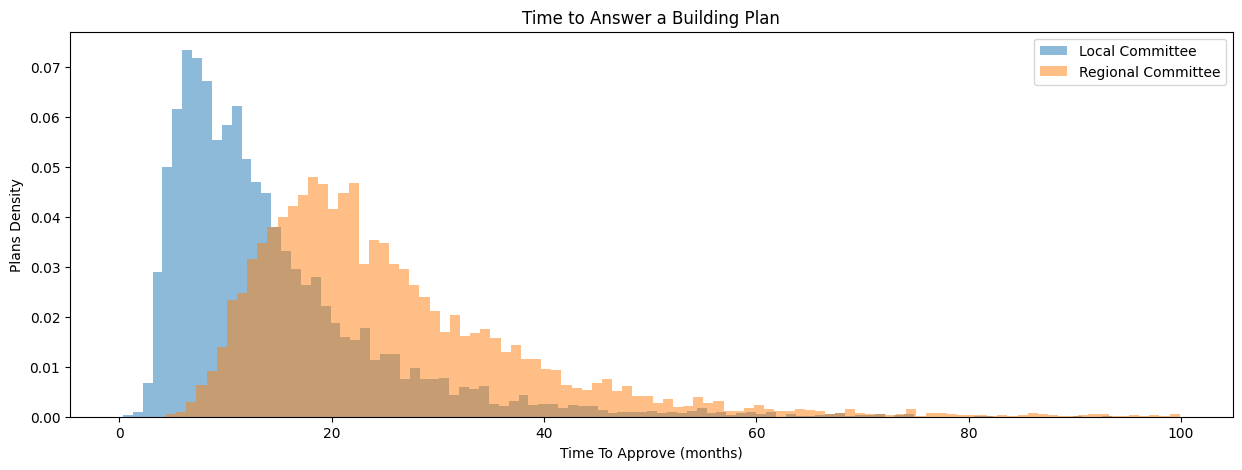

In [17]:
time_to_answer_in_months = plan_df_with_time_to_decision['time_to_answer_days'] / 30
time_to_answer_remove_outliers_mask = time_to_answer_in_months < 100

time_to_answer_local = time_to_answer_in_months[time_to_answer_remove_outliers_mask & (plan_df_with_time_to_decision['jurisdiction'] == 'מקומית')]
time_to_answer_county = time_to_answer_in_months[time_to_answer_remove_outliers_mask & (plan_df_with_time_to_decision['jurisdiction'] == 'מחוזית')]

# show to screen
plt.figure(figsize=(15, 5))
plt.hist(time_to_answer_local, bins=100, density=True, label='Local Committee', alpha=0.5)
plt.hist(time_to_answer_county, bins=100, density=True, label='Regional Committee', alpha=0.5)
plt.legend()
plt.title('Time to Answer a Building Plan')
plt.xlabel('Time To Approve (months)')
plt.ylabel('Plans Density')
plt.show()

# save to pdf
plt.figure(figsize=(7, 5))
plt.hist(time_to_answer_local, bins=100, density=True, label='Local Committee', alpha=0.5)
plt.hist(time_to_answer_county, bins=100, density=True, label='Regional Committee', alpha=0.5)
plt.legend()
plt.xlabel('Time To Approve (months)')
plt.ylabel('Plans Density')
plt.savefig('time_to_approve_per_committee.pdf')
plt.close()

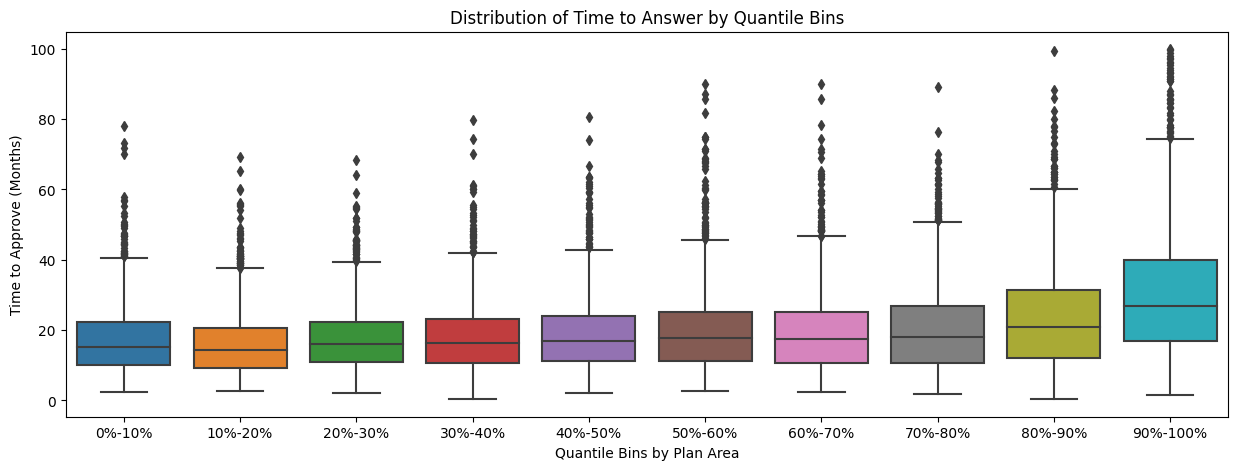

In [18]:
num_bins = 10
quantile_breakpoints = pd.qcut(plan_df_with_time_to_decision['area_in_sqm'], num_bins, labels=False)

# Create a DataFrame with the time to answer data and quantile bin labels
data = pd.DataFrame({
    'Time to Answer (Months)': time_to_answer_in_months[time_to_answer_remove_outliers_mask],
    'Quantile Bin': quantile_breakpoints
})

# Set the figure size
plt.figure(figsize=(15, 5))

# Create a violin plot
sns.boxplot(x='Quantile Bin', y='Time to Answer (Months)', data=data)

# Set plot title, x-axis label, and y-axis label
plt.title('Distribution of Time to Answer by Quantile Bins')
plt.xlabel('Quantile Bins by Plan Area')
plt.ylabel('Time to Approve (Months)')

bin_size = 100 / num_bins

# Modify the x-axis labels
xticklabels = [f'{int(i * bin_size)}%-{int((i + 1) * bin_size)}%' for i in range(num_bins)]
plt.xticks(range(num_bins), xticklabels)

# Show the plot
plt.show()


# save to pdf
plt.figure(figsize=(9, 5))
sns.boxplot(x='Quantile Bin', y='Time to Answer (Months)', data=data)

plt.xlabel('Quantile Bins by Plan Area')
plt.ylabel('Time to Approve (Months)')
plt.xticks(range(num_bins), xticklabels)
plt.savefig('time_to_answer_by_area.pdf')
plt.close()

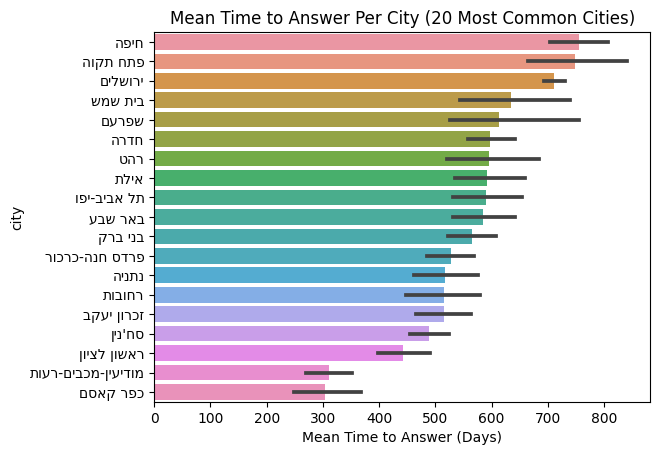

In [19]:
biggest_cities = plan_df_with_time_to_decision['PLAN_COUNTY_NAME'].value_counts().iloc[:20].index
# remove the empty city name which is the largest
biggest_cities = biggest_cities[biggest_cities != '']

plan_df_top_cities = plan_df_with_time_to_decision[plan_df_with_time_to_decision['PLAN_COUNTY_NAME'].isin(biggest_cities)].copy()
plan_df_top_cities['PLAN_COUNTY_NAME_REV'] = plan_df_top_cities['PLAN_COUNTY_NAME'].str[::-1]
plan_df_top_cities_agg = plan_df_top_cities.groupby('PLAN_COUNTY_NAME_REV')['time_to_answer_days'].mean().reset_index().sort_values(by='time_to_answer_days', ascending=False)
sns.barplot(x='time_to_answer_days', y='PLAN_COUNTY_NAME_REV', data=plan_df_top_cities, errorbar='ci', order=plan_df_top_cities_agg['PLAN_COUNTY_NAME_REV'])


# Set the plot title and labels
plt.title('Mean Time to Answer Per City (20 Most Common Cities)')
plt.xlabel('Mean Time to Answer (Days)')
plt.ylabel('city')

# Display the plot
plt.show()

# to pdf
plt.figure(figsize=(10, 5))
sns.barplot(x='time_to_answer_days', y='PLAN_COUNTY_NAME_REV', data=plan_df_top_cities, errorbar='ci', order=plan_df_top_cities_agg['PLAN_COUNTY_NAME_REV'])
# Set the plot title and labels
plt.xlabel('Mean Time to Approve (Days)')
plt.ylabel('city')
plt.savefig('time_to_answer_per_city.pdf')
plt.close()


In [20]:
# Create a copy of the DataFrame with the center coordinates as separate columns
df_center = plan_df_with_time_to_decision.copy()
df_center['latitude'] = df_center['geom'].centroid.y
df_center['longitude'] = df_center['geom'].centroid.x

# Define the color scale range and midpoint
color_scale_min = df_center['time_to_answer_days'].min()
color_scale_max = 1000  # Set the maximum value for the color scale
color_scale_midpoint = color_scale_max

# Plot the centers on a map with color-coded dots based on time to answer days
fig = px.scatter_mapbox(df_center, lat='latitude', lon='longitude', color='time_to_answer_days',
                        color_continuous_scale='Reds', range_color=(color_scale_min, color_scale_max),
                        color_continuous_midpoint=color_scale_midpoint, hover_data=['PL_NAME'],
                        mapbox_style='open-street-map', zoom=10)

# Set the color bar title
fig.update_layout(coloraxis_colorbar_title='Time to Answer (Days)')

# Show the plot
fig.show()


/var/folders/l5/f4qh10xj78l_nszjzjcnf_th0000gr/T/ipykernel_13866/2830293012.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_center['latitude'] = df_center['geom'].centroid.y
/var/folders/l5/f4qh10xj78l_nszjzjcnf_th0000gr/T/ipykernel_13866/2830293012.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_center['longitude'] = df_center['geom'].centroid.x


## Prepare Features

### Statistical Area Features

In [21]:
def get_statistical_area_geography_gdf():
    """
    Download from lamas, link: https://www.cbs.gov.il/he/Documents/statisticalareas_2020_demography.gdb.zip
    """
    dataset_path = 'statisticalareas_2020_demography.gdb'

    layers = fiona.listlayers(dataset_path)
    statistical_areas_gdf = gpd.read_file(dataset_path, driver='fileGDB', layer=layers[0])
    # it has coordinates in the New Israeli Grid
    statistical_areas_gdf.crs = 'EPSG:2039'
    # Transform the GeoDataFrame to WGS84 (EPSG:4326)
    statistical_areas_gdf = statistical_areas_gdf.to_crs('EPSG:4326')

    return statistical_areas_gdf


statistical_areas_gdf = get_statistical_area_geography_gdf()
statistical_areas_gdf.head()

,SEMEL_YISHUV,STAT11,YISHUV_STAT11,SHEM_YISHUV,SHEM_YISHUV_ENGLISH,Stat11_Unite,Stat11_Ref,Main_Function_Code,Main_Function_Txt,Religion_yishuv_Code,...,age_55_59,age_60_64,age_65_69,age_70_74,age_75_79,age_80_84,age_85_up,Shape_Length,Shape_Area,geometry
0,128,1.0,1280001,גת רימון,GAT RIMMON,1,NaN,1.0,מגורים,1.0,...,7.0,18.0,15.0,15.0,7.0,4.0,9.0,3035.931449,4.389580e+05,"MULTIPOLYGON (((34.88526 32.07002, 34.88537 32..."
1,130,1.0,1300001,משמר העמק,MISHMAR HAEMEQ,1,NaN,1.0,מגורים,1.0,...,71.0,54.0,61.0,39.0,37.0,38.0,37.0,4180.334358,8.684028e+05,"MULTIPOLYGON (((35.15117 32.60868, 35.14997 32..."
2,132,1.0,1320001,כפר ברוך,KEFAR BARUKH,1,NaN,1.0,מגורים,1.0,...,11.0,11.0,21.0,27.0,10.0,5.0,7.0,5339.434603,1.056815e+06,"MULTIPOLYGON (((35.18732 32.64935, 35.18815 32..."
3,133,1.0,1330001,גבת,GEVAT,1,NaN,1.0,מגורים,1.0,...,24.0,33.0,44.0,59.0,30.0,25.0,20.0,5398.806614,1.765327e+06,"MULTIPOLYGON (((35.21996 32.67629, 35.22123 32..."
4,134,1.0,1340001,יפעת,YIF'AT,1,NaN,1.0,מגורים,1.0,...,44.0,33.0,41.0,56.0,34.0,36.0,15.0,5252.059246,1.483198e+06,"MULTIPOLYGON (((35.22637 32.68440, 35.22743 32..."


In [22]:
def get_statistical_area_cities():
    """
    Download from lamas. It's in the category of 'אזורים סטטיסטיים בתוך עיריות ומועצות מקומיות' in the link:
    https://www.cbs.gov.il/he/publications/Pages/2023/%D7%90%D7%A4%D7%99%D7%95%D7%9F-%D7%99%D7%97%D7%99%D7%93%D7%95%D7%AA-%D7%92%D7%90%D7%95%D7%92%D7%A8%D7%A4%D7%99%D7%95%D7%AA-%D7%95%D7%A1%D7%99%D7%95%D7%95%D7%92%D7%9F-%D7%9C%D7%A4%D7%99-%D7%94%D7%A8%D7%9E%D7%94-%D7%94%D7%97%D7%91%D7%A8%D7%AA%D7%99%D7%AA-%D7%9B%D7%9C%D7%9B%D7%9C%D7%99%D7%AA-%D7%A9%D7%9C-%D7%94%D7%90%D7%95%D7%9B%D7%9C%D7%95%D7%A1%D7%99%D7%99%D7%94-%D7%91%D7%A9%D7%A0%D7%AA-2019.aspx
    """
    df_statistical_areas_data_cities = pd.read_excel('T13.xlsx')
    df_statistical_areas_data_cities = df_statistical_areas_data_cities.iloc[9:]

    df_statistical_areas_data_cities = pd.DataFrame({'city_heb': df_statistical_areas_data_cities.iloc[:, 2],
                                                    'city_eng': df_statistical_areas_data_cities.iloc[:, 3],
                                                    'city_code': df_statistical_areas_data_cities.iloc[:, 1],
                                                    'city_cluster_2019': df_statistical_areas_data_cities.iloc[:, 4],
                                                    'city_cluster_2017': df_statistical_areas_data_cities.iloc[:, 5],
                                                    'staistical_area_code': df_statistical_areas_data_cities.iloc[:, 6],
                                                    'population_in_area': df_statistical_areas_data_cities.iloc[:, 7],
                                                    'index_value_2019': df_statistical_areas_data_cities.iloc[:, 8],
                                                    'rank_2019': df_statistical_areas_data_cities.iloc[:, 9],
                                                    'cluster_2019': df_statistical_areas_data_cities.iloc[:, 10],
                                                    'cluster_2017': df_statistical_areas_data_cities.iloc[:, 11]})
    return df_statistical_areas_data_cities


df_statistical_areas_data_cities = get_statistical_area_cities()
df_statistical_areas_data_cities.head()

,city_heb,city_eng,city_code,city_cluster_2019,city_cluster_2017,staistical_area_code,population_in_area,index_value_2019,rank_2019,cluster_2019,cluster_2017
9,אופקים,OFAQIM,31,3,3,6,6123.034701,-1.723285,106,1,1
10,אופקים,OFAQIM,31,3,3,3,3044.829053,-0.964277,254,3,3
11,אופקים,OFAQIM,31,3,3,4,3043.845597,-0.908773,271,3,3
12,אופקים,OFAQIM,31,3,3,2,2773.050577,-0.541246,375,4,3
13,אופקים,OFAQIM,31,3,3,1,5246.151512,-0.539951,376,4,4


In [23]:
def get_statistical_area_settlements():
    """
    Download from lamas. It's in the category of 'יישובים בתוך מועצות אזוריות' in the link:
    https://www.cbs.gov.il/he/publications/Pages/2023/%D7%90%D7%A4%D7%99%D7%95%D7%9F-%D7%99%D7%97%D7%99%D7%93%D7%95%D7%AA-%D7%92%D7%90%D7%95%D7%92%D7%A8%D7%A4%D7%99%D7%95%D7%AA-%D7%95%D7%A1%D7%99%D7%95%D7%95%D7%92%D7%9F-%D7%9C%D7%A4%D7%99-%D7%94%D7%A8%D7%9E%D7%94-%D7%94%D7%97%D7%91%D7%A8%D7%AA%D7%99%D7%AA-%D7%9B%D7%9C%D7%9B%D7%9C%D7%99%D7%AA-%D7%A9%D7%9C-%D7%94%D7%90%D7%95%D7%9B%D7%9C%D7%95%D7%A1%D7%99%D7%99%D7%94-%D7%91%D7%A9%D7%A0%D7%AA-2019.aspx
    """
    df_statistical_areas_data_settlements = pd.read_excel('T09.xlsx')
    df_statistical_areas_data_settlements = df_statistical_areas_data_settlements.iloc[9:]

    df_statistical_areas_data_settlements = pd.DataFrame({'council_heb': df_statistical_areas_data_settlements.iloc[:, 1],
                                                        'council_eng': df_statistical_areas_data_settlements.iloc[:, 2],
                                                        'council_cluster_2019': df_statistical_areas_data_settlements.iloc[:, 3],
                                                        'council_cluster_2017': df_statistical_areas_data_settlements.iloc[:, 4],
                                                        'settlement_code': df_statistical_areas_data_settlements.iloc[:, 5],
                                                        'settlement_heb': df_statistical_areas_data_settlements.iloc[:, 6],
                                                        'settlement_eng': df_statistical_areas_data_settlements.iloc[:, 7],
                                                        'population_in_area': df_statistical_areas_data_settlements.iloc[:, 9],
                                                        'index_value_2019': df_statistical_areas_data_settlements.iloc[:, 10],
                                                        'rank_2019': df_statistical_areas_data_settlements.iloc[:, 11],
                                                        'cluster_2019': df_statistical_areas_data_settlements.iloc[:, 12],
                                                        'cluster_2017': df_statistical_areas_data_settlements.iloc[:, 13]})

    return df_statistical_areas_data_settlements


df_statistical_areas_data_settlements = get_statistical_area_settlements()
df_statistical_areas_data_settlements.head()

,council_heb,council_eng,council_cluster_2019,council_cluster_2017,settlement_code,settlement_heb,settlement_eng,population_in_area,index_value_2019,rank_2019,cluster_2019,cluster_2017
9,אל - בטוף,AL-BATOF,2,2,528,עוזייר,UZEIR,3276.152928,-1.554205,22,2,1
10,אל - בטוף,AL-BATOF,2,2,539,רומאנה,RUMMANE,1212.310443,-1.438988,27,2,2
11,אל - בטוף,AL-BATOF,2,2,997,רומת הייב,RUMAT HEIB,2046.91886,-1.294821,36,2,2
12,אל - בטוף,AL-BATOF,2,2,993,חמאם,HAMAM,1503.410491,-0.806535,84,3,3
13,אל קסום,AL-KASUM,1,1,1346,תרבין א-צאנע (יישוב),TARABIN AS-SANI,1138.5968,-3.3135,3,1,1


In [24]:
def process_lamas_data(statistical_areas_gdf, df_statistical_areas_data_cities, df_statistical_areas_data_settlements):
    
    def get_statistical_area_data_in_city(settlement_code, area_code):
        df_stastical_this_area = df_statistical_areas_data_cities[(df_statistical_areas_data_cities['city_code'] == settlement_code) & (df_statistical_areas_data_cities['staistical_area_code'] == area_code)]
        if df_stastical_this_area.shape[0] != 0:
            return df_stastical_this_area[['city_cluster_2019', 'city_cluster_2017', 'population_in_area', 'index_value_2019', 'rank_2019', 'cluster_2019', 'cluster_2017']].iloc[0].values
        return None

    def get_statistical_area_data_in_settlement(settlement_code):
        df_stastical_this_area = df_statistical_areas_data_settlements[(df_statistical_areas_data_settlements['settlement_code'] == settlement_code)]
        if df_stastical_this_area.shape[0] != 0:
            return df_stastical_this_area[['council_cluster_2019', 'council_cluster_2017', 'population_in_area', 'index_value_2019', 'rank_2019', 'cluster_2019', 'cluster_2017']].iloc[0].values
        return None

    def get_lamas_data_for_statistical_area(row):
        settlement_code = str(row['SEMEL_YISHUV'])
        area_code = str(row['YISHUV_STAT11'])
        # remove the settlement code from the area code
        area_code = area_code[len(settlement_code):]
        
        if area_code == '':       
            # teritory without jurisdiction
            return np.full((7,), np.nan)
            
        area_code = int(area_code)
        settlement_code = int(settlement_code)
        
        df_stastical_this_area = get_statistical_area_data_in_city(settlement_code, area_code)
        if df_stastical_this_area is not None:
            return df_stastical_this_area
        
        if area_code == 1:
            # settlements should have only a single statistical area
            df_stastical_this_area = get_statistical_area_data_in_settlement(settlement_code)
            if df_stastical_this_area is not None:
                return df_stastical_this_area
        
        return np.full((7,), np.nan)

    lamas_data = statistical_areas_gdf.apply(get_lamas_data_for_statistical_area, axis=1)
    lamas_data = pd.DataFrame(np.vstack(lamas_data.values), columns=['bigger_entity_cluster_2019', 'bigger_entity_cluster_2017', 
                                                            'population_in_area', 'index_value_2019', 'rank_2019', 'cluster_2019', 'cluster_2017'])
    statistical_areas_gdf = pd.concat([statistical_areas_gdf, lamas_data], axis=1)
    return statistical_areas_gdf


statistical_areas_gdf = process_lamas_data(statistical_areas_gdf, df_statistical_areas_data_cities, df_statistical_areas_data_settlements)

statistical_areas_gdf.head()

,SEMEL_YISHUV,STAT11,YISHUV_STAT11,SHEM_YISHUV,SHEM_YISHUV_ENGLISH,Stat11_Unite,Stat11_Ref,Main_Function_Code,Main_Function_Txt,Religion_yishuv_Code,...,Shape_Length,Shape_Area,geometry,bigger_entity_cluster_2019,bigger_entity_cluster_2017,population_in_area,index_value_2019,rank_2019,cluster_2019,cluster_2017
0,128,1.0,1280001,גת רימון,GAT RIMMON,1,NaN,1.0,מגורים,1.0,...,3035.931449,4.389580e+05,"MULTIPOLYGON (((34.88526 32.07002, 34.88537 32...",9,9,325.699728,1.511635,879,9,9
1,130,1.0,1300001,משמר העמק,MISHMAR HAEMEQ,1,NaN,1.0,מגורים,1.0,...,4180.334358,8.684028e+05,"MULTIPOLYGON (((35.15117 32.60868, 35.14997 32...",7,7,1271.143674,-1.066143,56,2,3
2,132,1.0,1320001,כפר ברוך,KEFAR BARUKH,1,NaN,1.0,מגורים,1.0,...,5339.434603,1.056815e+06,"MULTIPOLYGON (((35.18732 32.64935, 35.18815 32...",8,8,601.714502,0.779527,543,7,7
3,133,1.0,1330001,גבת,GEVAT,1,NaN,1.0,מגורים,1.0,...,5398.806614,1.765327e+06,"MULTIPOLYGON (((35.21996 32.67629, 35.22123 32...",8,8,918.74471,1.285539,795,8,9
4,134,1.0,1340001,יפעת,YIF'AT,1,NaN,1.0,מגורים,1.0,...,5252.059246,1.483198e+06,"MULTIPOLYGON (((35.22637 32.68440, 35.22743 32...",8,8,1183.917081,0.835119,574,7,7


In [25]:
statistical_areas_gdf['bigger_entity_cluster_2019'].isna().sum() / statistical_areas_gdf.shape[0] * 100

17.508628804518356

After checking with the Lamas data, seems like they didn't gathered data for some settlements. <br/>
Also, they gathered data for housing statistical areas only, leaving industrial areas without data.

In [26]:
STATISTICAL_CLMS_SUM = ['Pop_Total', 'Male_Total', 'Female_Total', 'age_0_4', 'age_5_9', 'age_10_14', 'age_15_19', 'age_20_24', 'age_25_29',
        'age_30_34', 'age_35_39', 'age_40_44', 'age_45_49', 'age_50_54', 'age_55_59', 'age_60_64', 'age_65_69', 'age_70_74',
        'age_75_79', 'age_80_84', 'age_85_up', 'population_in_area']
STATISTICAL_CLMS_MEAN = ['bigger_entity_cluster_2019', 'bigger_entity_cluster_2017', 'index_value_2019',
                         'rank_2019', 'cluster_2019', 'cluster_2017']
 

def try_float_else_nan(x):
    try:
        return float(x)
    except:
        return np.nan

def merge_plans_with_statistical_areas(plan_gdf, statistical_areas_gdf):
    """
    A plan can have multiple statistical areas.
    This function sums some of the values of the statistical areas of the plan, and mean others 
    """
    plan_df_statistical_areas_data = gpd.sjoin(plan_gdf, statistical_areas_gdf, how='left', predicate='intersects')
    plan_df_statistical_areas_data['statistical_area_geom'] = plan_df_statistical_areas_data.merge(statistical_areas_gdf, left_on='YISHUV_STAT11', right_on='YISHUV_STAT11')['geometry']

    statistical_areas_gdf_clms = statistical_areas_gdf.columns.tolist()
    statistical_areas_gdf_clms.remove('geometry')

    new_rows = []
    for plan_id in tqdm(plan_df_statistical_areas_data['id'].unique()):
        plan_df = plan_df_statistical_areas_data[plan_df_statistical_areas_data['id'] == plan_id]
        
        if pd.isna(plan_df.iloc[0]['YISHUV_STAT11']):
            # no statistical area
            new_row = np.concatenate([[plan_id], np.full((len(STATISTICAL_CLMS_SUM + STATISTICAL_CLMS_MEAN),), np.nan)])
            
        else:
            # multiple statistical areas, take the mean or sum of the appropriate columns
            
            # drop na since sometimes a statistical area is not in the lamas data and it will generate nans
            # some data might be non-numeric for some reason, filter it out for each column of each plan individualy
            summed_values = []
            for clm in STATISTICAL_CLMS_SUM:
                values_for_sum = plan_df[clm].apply(try_float_else_nan)
                values_for_sum = values_for_sum[~values_for_sum.isna()]
                if values_for_sum.shape[0] != 0:
                    summed_values.append(values_for_sum.sum())
                else:
                    summed_values.append(np.nan)
            
            meaned_values = []
            for clm in STATISTICAL_CLMS_MEAN:
                values_for_mean = plan_df[clm].apply(try_float_else_nan)
                values_for_mean = values_for_mean[~values_for_mean.isna()]
                if values_for_mean.shape[0] != 0:
                    meaned_values.append(values_for_mean.mean())
                else:
                    meaned_values.append(np.nan)
            
            new_row = np.array([plan_id] + summed_values + meaned_values)
                
        new_rows.append(new_row)
    
    statistical_area_features = pd.DataFrame(np.array(new_rows), columns=['plan_id'] + STATISTICAL_CLMS_SUM + STATISTICAL_CLMS_MEAN)
    statistical_area_features['plan_id'] = statistical_area_features['plan_id'].astype(int)
    return statistical_area_features


statistical_area_features = merge_plans_with_statistical_areas(plan_df_with_time_to_decision, statistical_areas_gdf)
statistical_area_features.head()

100%|██████████| 13386/13386 [03:23<00:00, 65.87it/s]


,plan_id,Pop_Total,Male_Total,Female_Total,age_0_4,age_5_9,age_10_14,age_15_19,age_20_24,age_25_29,...,age_75_79,age_80_84,age_85_up,population_in_area,bigger_entity_cluster_2019,bigger_entity_cluster_2017,index_value_2019,rank_2019,cluster_2019,cluster_2017
0,4,24255.0,12430.0,11829.0,2669.0,2421.0,2450.0,2676.0,2409.0,2176.0,...,193.0,81.0,72.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,9,6294.0,3171.0,3121.0,736.0,579.0,438.0,383.0,390.0,528.0,...,103.0,68.0,33.0,5715.245471,5.0,4.0,0.076961,725.0,5.0,5.0
3,10,14642.0,7304.0,7340.0,2430.0,2060.0,1793.0,1743.0,1427.0,1117.0,...,79.0,29.0,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,11,1318.0,667.0,654.0,56.0,112.0,160.0,121.0,92.0,51.0,...,32.0,21.0,21.0,1287.484562,9.0,9.0,1.919865,984.0,10.0,9.0


### Area Changes Features

In [27]:
def get_plan_area_changes_df():
    
    def to_float(x):
        if x is None or x == '':
            return 0.0
        return float(x.replace('+', '').replace(',', ''))
    
    with get_mysql_con() as db_connection:
        plan_area_changes_df = pd.read_sql("SELECT * FROM plan_area_changes", db_connection)
    
    plan_area_changes_df['approved_state'] = plan_area_changes_df['approved_state'].apply(to_float)
    plan_area_changes_df['change_to_approved_state'] = plan_area_changes_df['change_to_approved_state'].apply(to_float)
    plan_area_changes_df['total_in_detailed_plan'] = plan_area_changes_df['total_in_detailed_plan'].apply(to_float)

    return plan_area_changes_df


area_changes_df = get_plan_area_changes_df()
area_changes_df.head()

/var/folders/l5/f4qh10xj78l_nszjzjcnf_th0000gr/T/ipykernel_13866/626193812.py:9: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



,id,plan_id,usage,measurement_unit,approved_state,change_to_approved_state,total_in_detailed_plan,total_in_mitaarit_plan,remarks
0,1,1,"מגורים (יח""ד)","יח""ד",12.0,8.00,20.00,,
1,2,1,"מגורים (מ""ר)","מ""ר",1270.2,336.15,1606.35,,
2,3,2,"מגורים (יח""ד)","יח""ד",16.0,0.00,16.00,,
3,4,2,"מגורים (מ""ר)","מ""ר",1440.0,100.00,1540.00,,
4,5,2,"מסחר (מ""ר)","מ""ר",400.0,0.00,400.00,,


In [28]:
def get_area_changes_features_df(area_changes_df, plan_df):
    area_usages = area_changes_df['usage'].unique().tolist()
    # both do not appear enough in the data to be useful
    remove_usages_from_data = ['דיורית (יח"ד)', 'דיור בהישג יד']
    for remove_usage in remove_usages_from_data:
        area_usages.remove(remove_usage)

    features = ['approved_state', 'change_to_approved_state', 'total_in_detailed_plan']

    clms = {'plan_id': []} | {f'{area_usage}_{feature}': [] for area_usage, feature in itertools.product(area_usages, features)}
    for plan_id in plan_df['id'].unique():
        clms['plan_id'].append(plan_id)
        
        area_changes_of_plan = area_changes_df[area_changes_df['plan_id'] == plan_id]
        
        for row in area_changes_of_plan.values:
            area_usage = row[2]
            if area_usage in remove_usages_from_data:
                continue
            
            for feature_idx, feature in enumerate(features):
                clms[f'{area_usage}_{feature}'].append(row[4 + feature_idx])
                
        should_be_length = len(clms['plan_id'])
        for key in clms.keys():
            if len(clms[key]) != should_be_length:
                clms[key].append(0)

    area_changes_flatten_df = pd.DataFrame(clms)
    return area_changes_flatten_df


area_changes_df = get_area_changes_features_df(area_changes_df, plan_df)

area_changes_df.head()

,plan_id,"מגורים (יח""ד)_approved_state","מגורים (יח""ד)_change_to_approved_state","מגורים (יח""ד)_total_in_detailed_plan","מגורים (מ""ר)_approved_state","מגורים (מ""ר)_change_to_approved_state","מגורים (מ""ר)_total_in_detailed_plan","מסחר (מ""ר)_approved_state","מסחר (מ""ר)_change_to_approved_state","מסחר (מ""ר)_total_in_detailed_plan",...,"דירות קטנות בישובים כפריים (יח""ד)_total_in_detailed_plan","דירות להשכרה (יח""ד)_approved_state","דירות להשכרה (יח""ד)_change_to_approved_state","דירות להשכרה (יח""ד)_total_in_detailed_plan","דיור מיוחד (יח""ד)_approved_state","דיור מיוחד (יח""ד)_change_to_approved_state","דיור מיוחד (יח""ד)_total_in_detailed_plan","דיור מיוחד (מ""ר)_approved_state","דיור מיוחד (מ""ר)_change_to_approved_state","דיור מיוחד (מ""ר)_total_in_detailed_plan"
0,1,12.0,8.0,20.0,1270.2,336.15,1606.35,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,16.0,0.0,16.0,1440.0,100.00,1540.00,400.0,0.0,400.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,172.0,26.0,198.0,17200.0,500.00,17700.00,1500.0,0.0,1500.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,6.0,2.0,8.0,719.0,155.00,874.00,287.0,-4.0,283.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0.0,0.0,0.0,1300.0,84.00,1384.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Plan Submitter Features

In [30]:
def get_table_1_8_1():
    with get_mysql_con() as con:
        df = pd.read_sql('SELECT * FROM tables_18_interests_in_plan', con=con)
    df = df[df['origin'] == '1.8.1'].reset_index(drop=True).copy()
    return df


df_table_1_8_1 = get_table_1_8_1()
df_table_1_8_1.head()

/var/folders/l5/f4qh10xj78l_nszjzjcnf_th0000gr/T/ipykernel_13866/94085484.py:3: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



,id,plan_id,origin,profession,type,description,name,license_number,corporate,city,street,house,phone,fax,email
0,33,15204,1.8.1,,משרד הבינוי והשיכון,None,משרד הבינוי והשיכון,,משרד הבינוי והשיכון,תל אביב- יפו,דרך בגין ) 1 (,125,03-7632840,03-7632841,HagitZ@moch.gov.il
1,107,19288,1.8.1,,פרטי,None,חיים כהן,,,כפר גדעון,) 1 (,,050-7747029,,ezrabeni1@walla.co.il
2,118,18617,1.8.1,,חברה/תאגיד ממשלתי,None,"חברה/תאגיד ממשלתי, יוסף חזן",,"גלא בשרים ואחסנה בקירור בע""ם",בית שמש,יהודה הלוי,19,,,hazanyosef90@gmail.com
3,148,20290,1.8.1,מעוצה,רשות מקומית,None,רשות מקומית,,מעוצה מקומית דיר חנא,דיר חנא,) 1 (,,04-6789039,04-6782013,engineer@deir-hanna.muni.il
4,209,7901,1.8.1,,רשות מקומית,None,רשות מקומית,,עמק יזרעאל,עפולה,) 1 (,,04-6520045,04-6520050,dov@emekyizrael.org.il


In [31]:
non_empty_most_common_plan_submitter_name = [name for name, count in Counter(df_table_1_8_1['name']).most_common(10) if name != '']

non_empty_most_common_plan_submitter_name

['רשות מקומית',
 'ועדה מקומית',
 'חברה/תאגיד ממשלתי',
 'רשות מקרקעי ישראל',
 'משרד הבינוי והשיכון',
 'רשות הטבע והגנים',
 'משרד החקלאות',
 'ועדה מקומית, ועדה מקומית',
 'רשות מקומית, רשות מקומית']

In [32]:
common_plan_submitter_type = [name for name, count in Counter(df_table_1_8_1['type']).most_common(8)]

common_plan_submitter_type

['פרטי',
 'רשות מקומית',
 'אחר',
 'ועדה מקומית',
 'חברה/תאגיד ממשלתי',
 'רשות מקרקעי ישראל',
 'מייצג בא כח',
 'משרד הבינוי והשיכון']

In [35]:
def create_count_feature(df, clm_name, list_of_values_to_inclued):
    
    feature_clms = {f'{clm_name}_{value}': [] for value in list_of_values_to_inclued}
    computed_values = {'plan_id': []} | feature_clms | {f'{clm_name}_other': []}
    for plan_id, grp in df.groupby('plan_id'):
        computed_values['plan_id'].append(plan_id)
        
        value_counts = grp[clm_name].value_counts()
        count_of_other_values = 0
        for cat_name, cnt in zip(value_counts.index, value_counts.values):
            if f'{clm_name}_{cat_name}' in feature_clms.keys():
                computed_values[f'{clm_name}_{cat_name}'].append(1)
            else:
                count_of_other_values += cnt
        
        value_in_other = 0 if count_of_other_values == 0 else 1
        computed_values[f'{clm_name}_other'].append(value_in_other)

        for key in computed_values.keys():
            if len(computed_values[key]) != len(computed_values['plan_id']):
                computed_values[key].append(0)
    
    return pd.DataFrame(computed_values)


plan_submitter_name_features = create_count_feature(df_table_1_8_1, 'name', non_empty_most_common_plan_submitter_name)
plan_submitter_name_features.head()

,plan_id,name_רשות מקומית,name_ועדה מקומית,name_חברה/תאגיד ממשלתי,name_רשות מקרקעי ישראל,name_משרד הבינוי והשיכון,name_רשות הטבע והגנים,name_משרד החקלאות,"name_ועדה מקומית, ועדה מקומית","name_רשות מקומית, רשות מקומית",name_other
0,34,1,0,0,0,0,0,0,0,0,1
1,50,1,0,0,0,0,0,0,0,0,1
2,77,0,0,0,0,0,0,0,0,0,1
3,82,0,0,0,0,0,0,0,0,0,1
4,120,1,0,0,0,0,0,0,0,0,0


In [36]:
plan_submitter_type_features = create_count_feature(df_table_1_8_1, 'type', common_plan_submitter_type)

plan_submitter_type_features.head()

,plan_id,type_פרטי,type_רשות מקומית,type_אחר,type_ועדה מקומית,type_חברה/תאגיד ממשלתי,type_רשות מקרקעי ישראל,type_מייצג בא כח,type_משרד הבינוי והשיכון,type_other
0,34,1,1,0,0,0,0,0,0,0
1,50,1,1,0,0,0,0,0,0,0
2,77,1,0,0,0,0,0,0,0,0
3,82,0,0,1,0,0,0,0,0,0
4,120,0,1,0,0,0,0,0,0,0


In [37]:
plan_submitter_features = plan_submitter_name_features.merge(plan_submitter_type_features, on='plan_id', how='outer')
plan_submitter_features = plan_submitter_features.fillna(0)

plan_submitter_features.head()

,plan_id,name_רשות מקומית,name_ועדה מקומית,name_חברה/תאגיד ממשלתי,name_רשות מקרקעי ישראל,name_משרד הבינוי והשיכון,name_רשות הטבע והגנים,name_משרד החקלאות,"name_ועדה מקומית, ועדה מקומית","name_רשות מקומית, רשות מקומית",name_other,type_פרטי,type_רשות מקומית,type_אחר,type_ועדה מקומית,type_חברה/תאגיד ממשלתי,type_רשות מקרקעי ישראל,type_מייצג בא כח,type_משרד הבינוי והשיכון,type_other
0,34,1,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0
1,50,1,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0
2,77,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0
3,82,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0
4,120,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


### Allowed Usages Features

In [38]:
def get_table_4():
    with get_mysql_con() as con:
        df = pd.read_sql('SELECT * FROM meirim.table_4_area_designation_and_usage', con=con)
    return df


df_table_4 = get_table_4()
df_table_4.head()

/var/folders/l5/f4qh10xj78l_nszjzjcnf_th0000gr/T/ipykernel_13866/1037058274.py:3: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



,id,plan_id,category_number,category,father_category_number,father_category,text
0,45,15204,4.1.1,שימושים,4.1,מגורים,"מבני מגורים, חניה, מרחבים מוגנים, מרפסות, חדרי..."
1,46,15204,4.1.2,הוראות,4.1,מגורים,תנאים למתן היתרי בניה \nתנאי להיתר - תוכנית בי...
2,47,15204,4.2.1,שימושים,4.2,מבנים ומוסדות ציבור,"מבנים למוסדות חינוך, תרבות, דת, מנהל ציבורי, ב..."
3,48,15204,4.3.1,שימושים,4.3,שטח ציבורי פתוח,"גינון, העברת תשתיות, גני משחקים, שבילים להולכי..."
4,49,15204,4.4.1,שימושים,4.4,דרך מאושרת,"מסעה, מדרכה, חניה, גינון, טיפול נופי, תשתיות, ..."


In [39]:
def create_tbl_4_comma_count_feature(df_tbl_4, top_n):
    
    df_tbl_4 = df_tbl_4[df_tbl_4['category'] == 'שימושים'].copy()
    df_tbl_4['comma_count'] = df_tbl_4['text'].apply(lambda x: x.count(','))
    
    most_common_cats = [name for name, val in Counter(df_tbl_4['father_category']).most_common(top_n)]
    
    feature_clm_format = 'tbl_4_number_of_usages_{}'
    feature_clms = {feature_clm_format.format(value): [] for value in most_common_cats}
    computed_values = {'plan_id': []} | feature_clms | feature_clms | {feature_clm_format.format('other'): []}
    
    for plan_id, grp in df_tbl_4.groupby('plan_id'):
        computed_values['plan_id'].append(plan_id)
        
        curr_plan_computed_values = {}
        for cat, comma_count in grp[['father_category', 'comma_count']].values:
            feature_clm_after_format = feature_clm_format.format(cat)
            cat_to_work_on = feature_clm_after_format if feature_clm_after_format in feature_clms.keys() else feature_clm_format.format('other')
            
            if cat_to_work_on not in curr_plan_computed_values:
                curr_plan_computed_values[cat_to_work_on] = 0
            curr_plan_computed_values[cat_to_work_on] += comma_count
        
        for cat, comma_count in curr_plan_computed_values.items():
            computed_values[cat].append(comma_count)

        for key in computed_values.keys():
            if len(computed_values[key]) != len(computed_values['plan_id']):
                computed_values[key].append(0)
    
    return pd.DataFrame(computed_values)


tbl_4_comma_count_feature_df = create_tbl_4_comma_count_feature(df_table_4, 50)
tbl_4_comma_count_feature_df.head()

,plan_id,tbl_4_number_of_usages_דרך מאושרת,tbl_4_number_of_usages_דרך מוצעת,tbl_4_number_of_usages_מגורים ב',tbl_4_number_of_usages_שטח ציבורי פתוח,tbl_4_number_of_usages_מגורים א',tbl_4_number_of_usages_מבנים ומוסדות ציבור,tbl_4_number_of_usages_מגורים ג',tbl_4_number_of_usages_קרקע חקלאית,tbl_4_number_of_usages_שביל,...,tbl_4_number_of_usages_פארק / גן ציבורי,tbl_4_number_of_usages_מבנים ומוסדות ציבור לחינוך,tbl_4_number_of_usages_שמורת טבע,tbl_4_number_of_usages_מגורים ומבנים ומוסדות ציבור,tbl_4_number_of_usages_יער,tbl_4_number_of_usages_משק עזר,tbl_4_number_of_usages_מגורים מסחר ומבנים ומוסדות ציבור,tbl_4_number_of_usages_מסחר ומבנים ומוסדות ציבור,tbl_4_number_of_usages_מסחר ותיירות,tbl_4_number_of_usages_other
0,34,0,10,0,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,50,4,4,0,4,9,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,77,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,82,0,0,0,0,5,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
4,120,0,0,0,0,0,9,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Plan Geographic Features

In [40]:
geographic_features_df = pd.DataFrame({'latitude': plan_df_with_time_to_decision['geom'].centroid.y, 'longitude': plan_df_with_time_to_decision['geom'].centroid.x, 'plan_id': plan_df_with_time_to_decision['id']})
geographic_features_df = geographic_features_df.reset_index(drop=True)

county = plan_df_with_time_to_decision['PLAN_COUNTY_NAME']
most_common_conties = [county for county, count in Counter(county).most_common(20) if county != '']
county = county.apply(lambda x: x if x in most_common_conties else 'other')

onehot = OneHotEncoder()
county_onehot = onehot.fit_transform(county.values.reshape(-1, 1)).toarray()
columns = onehot.get_feature_names_out(['county'])
county_onehot_df = pd.DataFrame(county_onehot, columns=columns)
geographic_features_df = pd.concat([geographic_features_df, county_onehot_df], axis=1)

geographic_features_df.head()

/var/folders/l5/f4qh10xj78l_nszjzjcnf_th0000gr/T/ipykernel_13866/619753240.py:1: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




,latitude,longitude,plan_id,county_other,county_אילת,county_באר שבע,county_בית שמש,county_בני ברק,county_זכרון יעקב,county_חדרה,...,county_מודיעין-מכבים-רעות,county_נתניה,county_סח'נין,county_פרדס חנה-כרכור,county_פתח תקוה,county_ראשון לציון,county_רהט,county_רחובות,county_שפרעם,county_תל אביב-יפו
0,32.116664,34.973295,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,31.157885,35.008987,8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,31.068613,35.040825,9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,31.325840,34.871220,10,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,32.195984,34.913504,11,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Committee Features

In [41]:
plan_df_with_time_to_decision['jurisdiction'].value_counts()

onehot = OneHotEncoder()
jurisdicion_onehot = onehot.fit_transform(plan_df_with_time_to_decision['jurisdiction'].values.reshape(-1, 1)).toarray()
columns = onehot.get_feature_names_out(['jurisdiction'])
committee_feature_df = pd.DataFrame(jurisdicion_onehot, columns=columns)
committee_feature_df['plan_id'] = plan_df_with_time_to_decision['id'].values

committee_feature_df.head()

,jurisdiction_מחוזית,jurisdiction_מקומית,plan_id
0,0.0,1.0,4
1,1.0,0.0,8
2,1.0,0.0,9
3,1.0,0.0,10
4,0.0,1.0,11


## Approval Time Forecasting

In [42]:
feature_groups = {
    'statistical_area_features': statistical_area_features.dropna(),
    'area_changes_features': area_changes_df,
    'plan_submitter_features': plan_submitter_features,
    'allowed_usages_features': tbl_4_comma_count_feature_df,
    'geographic_features': geographic_features_df,
    'county_features': committee_feature_df
}

df_with_all_features = None
for feature_group_name, feature_group_df in feature_groups.items():
    if df_with_all_features is None:
        df_with_all_features = feature_group_df
    else:
        df_with_all_features = df_with_all_features.merge(feature_group_df, on='plan_id')

# We need plans with data from the pdfs and plans with data from lamas, so we take the intersection
plans_with_all_features = df_with_all_features['plan_id'].values
len(plans_with_all_features)

1275

In [43]:
df_with_plan_id_and_time_to_decision = plan_df_with_time_to_decision[['id', 'time_to_answer_days']].copy()
df_with_plan_id_and_time_to_decision.rename(columns={'id': 'plan_id'}, inplace=True)

df_with_plan_id_and_time_to_decision.head()

,plan_id,time_to_answer_days
3,4,123
7,8,764
8,9,936
9,10,266
10,11,185


In [48]:
def train_and_eval_classifier(X: pd.DataFrame, y_days_to_approve: pd.Series, clf, show_cm=False):
    
    def transform_label(y):
        y_months = y / 30

        # Define the bins in months
        bins = [10, 15, 22, 33]

        # Assign labels based on the bins
        labels = ["10-", "10-15", "15-22", "22-33", "33+"]

        # Initialize the result vector
        result = []

        # Iterate through each value in y_months and assign the label based on the bins
        for value in y_months:
            if value < bins[0]:
                result.append(labels[0])
            elif value < bins[1]:
                result.append(labels[1])
            elif value < bins[2]:
                result.append(labels[2])
            elif value < bins[3]:
                result.append(labels[3])
            else:
                result.append(labels[4])

        return result

    X_clms = X.columns.tolist()
    X = X.values
    y = transform_label(y_days_to_approve.values)
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.2, random_state=42)

    clf.fit(X_train, y_train)
    dummy_clf = DummyClassifier()
    dummy_clf.fit(X_train, y_train)


    clf_pred = clf.predict(X_test)
    dummy_clf_pred = dummy_clf.predict(X_test)

    clf_acc = accuracy_score(y_test, clf_pred)
    dummy_acc = accuracy_score(y_test, dummy_clf_pred)

    print(f'clf acc: {clf_acc:.4f}, dummy acc: {dummy_acc:.4f}')
    
    if show_cm:
        cm = confusion_matrix(y_test, clf_pred, labels=clf.classes_, normalize='true')
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)

        fig, ax = plt.subplots(figsize=(10, 10))
        disp.plot(ax=ax)
        ax.set_xlabel('Predicted label (months)')
        ax.set_ylabel('True label (months)')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        plt.savefig('conf_mat.pdf')
    
    return clf, clf_acc, sorted(list(zip(X_clms, clf.feature_importances_)), key=lambda x: x[1], reverse=True)


def classify_given_feature_groups(feature_groups, plans_with_all_features, show_conf_mat=False):
    df_with_relevant_features = None
    for feature_group_df in feature_groups:
        if df_with_relevant_features is None:
            df_with_relevant_features = feature_group_df
        else:
            df_with_relevant_features = df_with_relevant_features.merge(feature_group_df, on='plan_id')
    
    df_with_relevant_features = df_with_relevant_features[df_with_relevant_features['plan_id'].isin(plans_with_all_features)]
    
    X = df_with_relevant_features.drop(columns=['time_to_answer_days', 'plan_id'])
    y = df_with_relevant_features['time_to_answer_days']
    clf = RandomForestClassifier(random_state=42, n_estimators=600, n_jobs=8)
    clf, acc, feature_importance = train_and_eval_classifier(X, y, clf, show_conf_mat)
    return acc, feature_importance

In [49]:
classify_given_feature_groups([statistical_area_features.dropna(), area_changes_df, df_with_plan_id_and_time_to_decision], plans_with_all_features)[0]

clf acc: 0.3059, dummy acc: 0.1961


0.3058823529411765

In [50]:
def create_feature_combinations_df(feature_groups, plans_with_all_features, df_with_plan_id_and_time_to_decision):
    feature_groups = list(feature_groups.items())
    feature_combinations = list(product([True, False], repeat=len(feature_groups)))
    results = []

    for combination in feature_combinations:
        selected_feature_groups = [feature_groups[i][1] for i, include in enumerate(combination) if include] + [df_with_plan_id_and_time_to_decision]
        feature_groups_names = [feature_groups[i][0] for i, include in enumerate(combination) if include]
        print(f'Feature groups: {feature_groups_names}')
        
        if len(feature_groups_names) == 0:
            continue
        
        accuracy, _ = classify_given_feature_groups(selected_feature_groups, plans_with_all_features)
        
        results.append(combination + (accuracy,))

    columns = [group_name for group_name, _ in feature_groups] + ['Accuracy']
    df = pd.DataFrame(results, columns=columns)
    
    return df

In [51]:
results_df = create_feature_combinations_df(feature_groups, plans_with_all_features, df_with_plan_id_and_time_to_decision)

results_df.head()

Feature groups: ['statistical_area_features', 'area_changes_features', 'plan_submitter_features', 'allowed_usages_features', 'geographic_features', 'county_features']
clf acc: 0.3765, dummy acc: 0.1961
Feature groups: ['statistical_area_features', 'area_changes_features', 'plan_submitter_features', 'allowed_usages_features', 'geographic_features']
clf acc: 0.3216, dummy acc: 0.1961
Feature groups: ['statistical_area_features', 'area_changes_features', 'plan_submitter_features', 'allowed_usages_features', 'county_features']
clf acc: 0.3529, dummy acc: 0.1961
Feature groups: ['statistical_area_features', 'area_changes_features', 'plan_submitter_features', 'allowed_usages_features']
clf acc: 0.3216, dummy acc: 0.1961
Feature groups: ['statistical_area_features', 'area_changes_features', 'plan_submitter_features', 'geographic_features', 'county_features']
clf acc: 0.3765, dummy acc: 0.1961
Feature groups: ['statistical_area_features', 'area_changes_features', 'plan_submitter_features', 'ge

,statistical_area_features,area_changes_features,plan_submitter_features,allowed_usages_features,geographic_features,county_features,Accuracy
0,True,True,True,True,True,True,0.376471
1,True,True,True,True,True,False,0.321569
2,True,True,True,True,False,True,0.352941
3,True,True,True,True,False,False,0.321569
4,True,True,True,False,True,True,0.376471


In [52]:
for feature_group_name in feature_groups.keys():
    accuracies_with_grp = results_df[results_df[feature_group_name] == True]['Accuracy']
    accuracies_without_grp = results_df[results_df[feature_group_name] == False]['Accuracy']

    print(f'Feature Group: {feature_group_name}, accuracies with group: {accuracies_with_grp.mean():.2f}±{accuracies_with_grp.std():.2f}, accuracies without group: {accuracies_without_grp.mean():.2f}±{accuracies_with_grp.std():2f}')
    # Perform t-test
    t_statistic, p_value = stats.ttest_ind(accuracies_with_grp, accuracies_without_grp, equal_var=False)

    # Check if the difference is statistically significant
    alpha = 0.05  # significance level
    if p_value < alpha:
        print(f"Feature Group '{feature_group_name}' has a statistically significant impact on accuracy.")
    else:
        print(f"Feature Group '{feature_group_name}' does not have a statistically significant impact on accuracy.")
    

Feature Group: statistical_area_features, accuracies with group: 0.33±0.03, accuracies without group: 0.32±0.030894
Feature Group 'statistical_area_features' does not have a statistically significant impact on accuracy.
Feature Group: area_changes_features, accuracies with group: 0.33±0.03, accuracies without group: 0.31±0.032942
Feature Group 'area_changes_features' has a statistically significant impact on accuracy.
Feature Group: plan_submitter_features, accuracies with group: 0.33±0.04, accuracies without group: 0.32±0.036062
Feature Group 'plan_submitter_features' does not have a statistically significant impact on accuracy.
Feature Group: allowed_usages_features, accuracies with group: 0.33±0.03, accuracies without group: 0.32±0.029681
Feature Group 'allowed_usages_features' does not have a statistically significant impact on accuracy.
Feature Group: geographic_features, accuracies with group: 0.34±0.03, accuracies without group: 0.31±0.026103
Feature Group 'geographic_features' 

clf acc: 0.3765, dummy acc: 0.1961


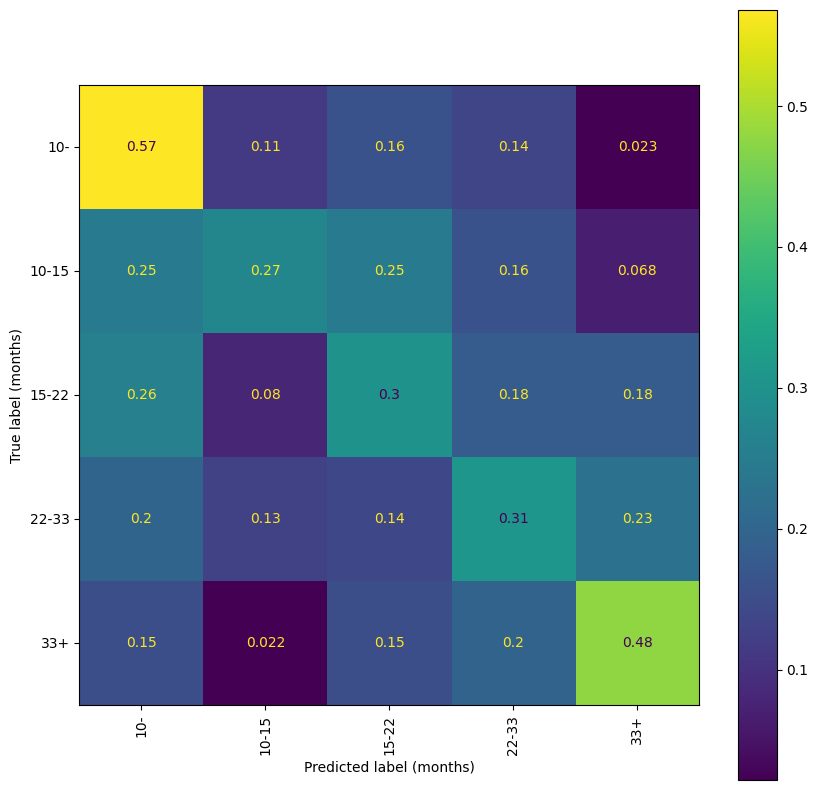

In [53]:
acc, important_features = classify_given_feature_groups(list(feature_groups.values()) + [df_with_plan_id_and_time_to_decision], plans_with_all_features, show_conf_mat=True)

In [54]:
important_features[:15]

[('latitude', 0.036261639599991145),
 ('longitude', 0.03434379879142996),
 ('מגורים (מ"ר)_total_in_detailed_plan', 0.029887488157691666),
 ('מגורים (מ"ר)_change_to_approved_state', 0.029174018165566),
 ('jurisdiction_מחוזית', 0.026128043764502357),
 ('מגורים (מ"ר)_approved_state', 0.02571209311420473),
 ('jurisdiction_מקומית', 0.024971949444386216),
 ('age_85_up', 0.022977624161113982),
 ('rank_2019', 0.022465626842982315),
 ('index_value_2019', 0.021999360383898624),
 ('מגורים (יח"ד)_total_in_detailed_plan', 0.021257372736554314),
 ('age_15_19', 0.020855360892002607),
 ('age_65_69', 0.020673734139178085),
 ('age_30_34', 0.020607262590484503),
 ('age_10_14', 0.020501018022867593)]